# Retirement Planner

---

## Environment Setup

In [23]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [24]:
# Set the random seed for resutls reproducibility (for testing purposes only)
np.random.seed(42)

---

## Portfolio Planner

In this activity, you will use the Alpaca API to grab historical data for a `60/40` portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [25]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [26]:
# Subset your tickers, then pull returns data:
# Set the ticker
ticker = ["SPY", "AGG"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns
df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)

In [27]:
# Display sample data
df.head()

AGG     SPY
                             close   close
time                                      
2019-01-02 00:00:00-05:00  106.585  249.89
2019-01-03 00:00:00-05:00  107.020  244.46
2019-01-04 00:00:00-05:00  106.695  252.41
2019-01-07 00:00:00-05:00  106.470  254.40
2019-01-08 00:00:00-05:00  106.420  256.65

---

## Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:

1. Calculate the daily returns for the SPY and AGG closing prices.

2. Calculate volatility for both the SPY and AGG closing prices.

3. Find the last day's closing price for both stocks and save those as variables

4. Run a Monte Carlo Simulation of at least `100` iterations and generate at least `30` years of closing prices

**Hint:** There are `252` trading days per year, so the number of records to generate for each Monte Carlo run will be `252 days * 30 years`.

In [28]:
# Calculate the daily roi for the stocks
returns = df.pct_change()
returns.dropna(inplace=True)
# Display sample data
returns.head()

AGG       SPY
                              close     close
time                                         
2019-01-03 00:00:00-05:00  0.004081 -0.021730
2019-01-04 00:00:00-05:00 -0.003037  0.032521
2019-01-07 00:00:00-05:00 -0.002109  0.007884
2019-01-08 00:00:00-05:00 -0.000470  0.008844
2019-01-09 00:00:00-05:00  0.000564  0.004130

In [29]:
# Compute daily volatility
avg_daily_returns = returns.mean()
std_daily_returns = returns.std() 

In [30]:
# Save the last day's closing price
spy_closing_price = df['SPY']['close'][-1]
agg_closing_price = df['AGG']['close'][-1]
total_closing_price = spy_closing_price + agg_closing_price

In [31]:
# Setup the Monte Carlo Parameters
# Start with 1 year
number_trading_days = 252 * 30
# Set the number of simulations
number_simulations = 500

In [32]:
# Run the Monte Carlo Simulation

portfolio_cumulative_returns = pd.DataFrame()
simulated_total_prices = pd.DataFrame()
simulated_prices = pd.DataFrame()

for n in range(number_simulations):
    
    simulated_spy_prices = [spy_closing_price]
    simulated_agg_prices = [agg_closing_price]
    simulated_total_price = [total_closing_price]
    
    for i in range(number_trading_days):
        
        simulated_price_spy = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_returns['SPY']['close'], std_daily_returns['SPY']['close']))
        simulated_spy_prices.append(simulated_price_spy)
        simulated_price_agg = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_returns['AGG']['close'], std_daily_returns['AGG']['close']))
        simulated_agg_prices.append(simulated_price_agg)
        simulated_total_price1 = simulated_price_spy + simulated_price_agg
        simulated_total_price.append(simulated_total_price1)
    
    simulated_total_prices[f"Simulation {n+1}"] = pd.Series(simulated_total_price)
    simulated_prices['SPY Prices'] = pd.Series(simulated_spy_prices)
    simulated_prices['AGG Prices'] = pd.Series(simulated_agg_prices)
    simulated_daily_returns = simulated_prices.pct_change()
    
    weights = [0.60, 0.40]
    
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

In [33]:
# Check that the simulation ran successfully
portfolio_cumulative_returns.head()

0         1         2         3         4         5         6    \
0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1  1.002924  0.995998  0.993588  0.999838  1.005672  1.006944  1.009403   
2  1.007960  0.999997  0.993066  0.999039  1.009071  0.998193  1.004124   
3  1.007370  1.000230  0.996722  0.993519  1.008616  1.001409  1.008138   
4  1.016195  1.003282  0.993394  0.999439  1.010294  0.996675  1.007118   

        7         8         9    ...       490       491       492       493  \
0  1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000  1.000000   
1  0.996555  1.001958  0.999350  ...  1.002268  0.995970  1.007308  1.000162   
2  0.986295  1.001345  1.007831  ...  1.004518  1.003370  1.010546  1.001968   
3  0.980579  1.001320  1.016103  ...  1.004743  1.006242  1.015345  1.003627   
4  0.978040  1.009298  1.006307  ...  1.006801  1.004678  1.014132  1.008910   

        494       495       496       497       498       499  
0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1  0.997898  1.003207  0.996440  0.994143  1.003209  0.997553  
2  0.999475  1.000275  0.996135  0.994774  1.003312  1.001444  
3  0.993172  0.999241  0.999998  1.000494  1.006827  1.000481  
4  0.999442  0.996474  0.994642  1.001385  1.011504  1.004130  

[5 rows x 500 columns]

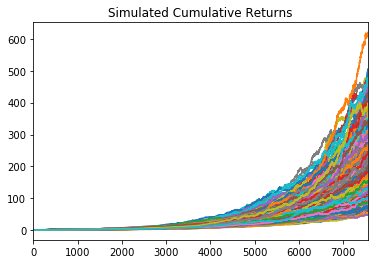

In [34]:
# Visualize the Simulation
portfolio_cumulative_returns.plot(legend=None, title="Simulated Cumulative Returns")

In [35]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
ending_returns = portfolio_cumulative_returns.iloc[-1, :]

In [36]:
# Display the 90% confidence interval for the ending returns
confidence_interval_90 = ending_returns.quantile(q=[0.05, 0.90])
confidence_interval_90.head()

0.05     94.186902
0.90    313.832717
Name: 7560, dtype: float64

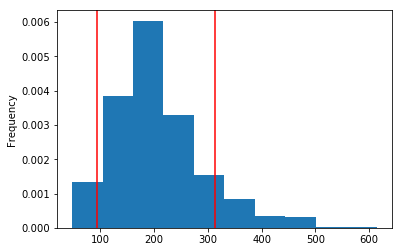

In [37]:
# Visualize the distribution of the ending returns
plt.figure();
ending_returns.plot(kind="hist", density=True, bins=10)
plt.axvline(confidence_interval_90.iloc[0], color='r')
plt.axvline(confidence_interval_90.iloc[1], color='r')

---

## Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at `30` years for the `10th`, `50th`, and `90th` percentiles?

2. Given an initial investment of `$20,000`, what is the expected return in dollars at the `10th`, `50th`, and `90th` percentiles?

3. Given the current projected annual income from the Plaid analysis, will a `4%` withdrawal rate meet or exceed that value at the `10th` percentile? Note: This is basically determining if retirement income is equivalent to current income.

4. How would a `50%` increase in the initial investment amount affect the `4%` retirement withdrawal? In other words, what happens if the initial investment had been bigger?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [38]:
# Compute cumulative returns
cumulative_returns_90 = ending_returns.quantile(q=0.90)
cumulative_returns_50 = ending_returns.quantile(q=0.50)
cumulative_returns_10 = ending_returns.quantile(q=0.10)

print(f"The cumulative returns at 30 years for the 90th percentile are {round((cumulative_returns_90 - 1) * 100 , 2)}%")
print(f"The cumulative returns at 30 years for the 50th percentile are {round((cumulative_returns_50 - 1) * 100 , 2)}%")
print(f"The cumulative returns at 30 years for the 10th percentile are {round((cumulative_returns_10 - 1) * 100 , 2)}%")

The cumulative returns at 30 years for the 90th percentile are 31283.27%
The cumulative returns at 30 years for the 50th percentile are 18852.6%
The cumulative returns at 30 years for the 10th percentile are 11617.88%


### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [39]:
# Set initial investment
initial_investment = 20000

# Compute expected portfolio return
expected_return_90 = round(initial_investment * cumulative_returns_90 , 2)
expected_return_50 = round(initial_investment * cumulative_returns_50 , 2)
expected_return_10 = round(initial_investment * cumulative_returns_10 , 2)

print(f"The expected portfolio return for the 90th percentile is ${expected_return_90}")
print(f"The expected portfolio return for the 50th percentile is ${expected_return_50}")
print(f"The expected portfolio return for the 10th percentile is ${expected_return_10}")

The expected portfolio return for the 90th percentile is $6276654.35
The expected portfolio return for the 50th percentile is $3790519.95
The expected portfolio return for the 10th percentile is $2343576.02


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [40]:
# Set Plaid's projected income
projected_income_plaid = 6085
# Calculate the 4% withdrawal for the ending return as retirement income
withdrawal_rate = 0.04
retirement_income = withdrawal_rate * expected_return_10 
# Determine if the retirement income meets or exceeds the current projected income
if retirement_income >= projected_income_plaid:
    print(f"The yearly income of ${retirement_income} is enough to cover the ${projected_income_plaid} yearly income needed")
    
else:
    print(f"The yearly income of ${retirement_income} is not enough to cover the ${projected_income_plaid} yearly income needed")

The yearly income of $93743.0408 is enough to cover the $6085 yearly income needed


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [41]:
# Re-calculate the retirement income with a 50% increase in the initial investment amount
new_initial_investment = 1.50 * initial_investment
new_expected_return_10 = round(new_initial_investment * cumulative_returns_10 , 2)
new_retirement_income = round((withdrawal_rate * new_expected_return_10) , 2)
if new_retirement_income >= projected_income_plaid:
    print(f"The yearly income of ${new_retirement_income} is enough to cover the ${projected_income_plaid} yearly income needed")
    
else:
    print(f"The yearly income of ${new_retirement_income} is not enough to cover the ${projected_income_plaid} yearly income needed")

The yearly income of $140614.56 is enough to cover the $6085 yearly income needed


### Optional Challenge

Use the Monte Carlo data and calculate the cumulative returns at the `5%`, `50%`, and `95%` quartiles and plot this data as a line chart to see how the cumulative returns change over the life of the investment.

In this section, you need to calculate and plot the cumulative returns for the median and `90%` confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [42]:
# Compute projected returns
quant_95 = portfolio_cumulative_returns.quantile(0.95, axis=1)
quant_50 = portfolio_cumulative_returns.quantile(0.50, axis=1)
quant_5 = portfolio_cumulative_returns.quantile(0.05, axis=1)

cumulative_returns_challenge = pd.concat([quant_95, quant_50, quant_5], axis="columns", join="inner")

# Display sample data
cumulative_returns_challenge.head()

0.95      0.50      0.05
0  1.000000  1.000000  1.000000
1  1.008779  1.000808  0.992970
2  1.012425  1.001775  0.991137
3  1.016106  1.002377  0.989296
4  1.017702  1.003324  0.987306

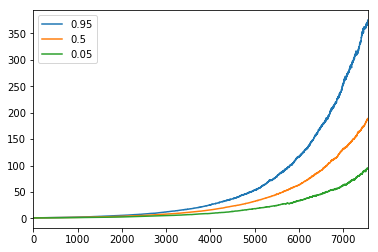

In [43]:
# Plot the cumulative returns over time
cumulative_returns_challenge.plot()

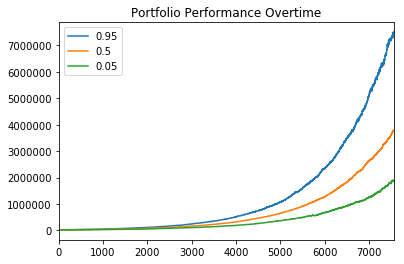

In [44]:
# Compute portfolio performance over time
portfolio_performance = cumulative_returns_challenge * 20000
# Plot projected performance over time
portfolio_performance.plot(title="Portfolio Performance Overtime")